# So sánh Preprocessing giữa Project 1 và Project1_Le

## Mục đích
So sánh kết quả preprocessing giữa hai notebook:
1. **Project 1 - Exe 1 - Sentiment Analysis.ipynb** (Phiên bản gốc)
2. **Project1_Le.ipynb** (Phiên bản Le)

## Phương pháp so sánh
1. Load cùng một sample dữ liệu từ cả hai phương pháp
2. So sánh từng bước preprocessing
3. Đánh giá kết quả cuối cùng
4. Phân tích sự khác biệt và tác động

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import re
import unicodedata
from underthesea import word_tokenize, pos_tag, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load sample data for comparison
data_folder = "/home/thinhdao/it_viec_project1/Du lieu cung cap"
files_folder = "/home/thinhdao/it_viec_project1/Du lieu cung cap/files"

# Load Reviews data
reviews_path = os.path.join(data_folder, "Reviews.xlsx")
reviews_df = pd.read_excel(reviews_path)

# Take a sample for comparison
sample_size = 100
np.random.seed(42)
sample_indices = np.random.choice(len(reviews_df), size=sample_size, replace=False)
sample_data = reviews_df.iloc[sample_indices].copy()

# Combine text fields
sample_data['combined_text'] = (
    sample_data['What I liked'].fillna('') + ' ' + 
    sample_data['Suggestions for improvement'].fillna('')
)

print(f"✅ Loaded sample data: {len(sample_data)} rows")
print(f"📊 Sample text preview:")
for i in range(3):
    text = sample_data['combined_text'].iloc[i][:100] + "..."
    print(f"  {i+1}. {text}")
    
sample_data.head()

✅ Loaded sample data: 100 rows
📊 Sample text preview:
  1. Thiết bị làm việc xịn xò, mỗi nhân viên được phát tai nghe rất xịn, có nhiều khóa học kĩ năng...
Khô...
  2. Văn phòng đẹp, sếp thoải mái, giờ giấc làm việc linh hoạt. Một số leader không tốt, dìm nhân viên.
C...
  3. Văn phòng đẹp, hiện đại. Môi trường năng động chuyên nghiệp
OT có lương, chế độ đầy đủ. OT lương cao...


,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,combined_text
7226,397,SMG Swiss Marketplace Group,June 2021,"Môi trường làm việc thoải mái, đồng nghiệp dễ ...","Thiết bị làm việc xịn xò, mỗi nhân viên được p...","Chính sách có chỗ chưa rõ ràng, cần cải thiện ...",5,5,5,5,5,5,Yes,"Thiết bị làm việc xịn xò, mỗi nhân viên được p..."
4591,253,KMS Technology,June 2018,Môi trường tốt,"Văn phòng đẹp, sếp thoải mái, giờ giấc làm việ...","Một số leader không tốt, dìm nhân viên.\nCơ hộ...",4,4,4,4,4,5,Yes,"Văn phòng đẹp, sếp thoải mái, giờ giấc làm việ..."
2522,182,FPT Software,November 2019,Môi trường chuyên nghiệp,"Văn phòng đẹp, hiện đại. Môi trường năng động ...",Công việc áp lực. Đầy thử thách. Yêu cầu phải ...,5,4,4,4,4,4,Yes,"Văn phòng đẹp, hiện đại. Môi trường năng động ..."
6225,338,Panasonic Vietnam Group – Panasonic R&D Center...,November 2023,"môi trường làm việc chuyên nghiệp, mọi người h...","Môi trường làm việc tốt, học tập được nhiều.\n...",nhà vệ sinh có thể hơi xa do một tầng chỉ có m...,5,3,5,4,4,5,Yes,"Môi trường làm việc tốt, học tập được nhiều.\n..."
2436,182,FPT Software,June 2020,Tốt cho fresher,"Nhiều dự án, công việc ổn định. Được senior kè...",Lương trung bình so với mặt bằng chung. Tăng l...,3,2,4,4,4,3,Yes,"Nhiều dự án, công việc ổn định. Được senior kè..."


In [3]:
# ==================== PREPROCESSOR FROM PROJECT 1 ====================
class VietnamesePreprocessor:
    """
    Vietnamese Text Preprocessor using external dictionary files (Project 1 version)
    """
    
    def __init__(self, files_directory=None):
        if files_directory is None:
            self.files_dir = files_folder
        else:
            self.files_dir = files_directory
        self.load_dictionaries()
        
    def load_dictionaries(self):
        """Load all dictionaries from external files"""
        
        # Load emoji dictionary
        emoji_path = os.path.join(self.files_dir, "emojicon.txt")
        self.emoji_dict = {}
        try:
            with open(emoji_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        self.emoji_dict[parts[0]] = parts[1]
            print(f"✅ [Project1] Loaded {len(self.emoji_dict)} emoji mappings")
        except:
            print("⚠️ [Project1] Could not load emoji dictionary")
            self.emoji_dict = {}
            
        # Load teencode dictionary
        teencode_path = os.path.join(self.files_dir, "teencode.txt")
        self.teencode_dict = {}
        try:
            with open(teencode_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        self.teencode_dict[parts[0]] = parts[1]
            print(f"✅ [Project1] Loaded {len(self.teencode_dict)} teencode mappings")
        except:
            print("⚠️ [Project1] Could not load teencode dictionary")
            self.teencode_dict = {}
            
        # Load Vietnamese stopwords
        stopwords_path = os.path.join(self.files_dir, "vietnamese-stopwords.txt")
        self.vietnamese_stopwords = set()
        try:
            with open(stopwords_path, 'r', encoding='utf-8') as f:
                for line in f:
                    word = line.strip().lower()
                    if word:
                        self.vietnamese_stopwords.add(word)
            print(f"✅ [Project1] Loaded {len(self.vietnamese_stopwords)} Vietnamese stopwords")
        except:
            print("⚠️ [Project1] Could not load Vietnamese stopwords")
            self.vietnamese_stopwords = set()
            
        # Load English-Vietnamese dictionary
        english_vnmese_path = os.path.join(self.files_dir, "english-vnmese.txt")
        self.english_vietnamese_dict = {}
        try:
            with open(english_vnmese_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        self.english_vietnamese_dict[parts[0].lower()] = parts[1]
            print(f"✅ [Project1] Loaded {len(self.english_vietnamese_dict)} English-Vietnamese mappings")
        except:
            print("⚠️ [Project1] Could not load English-Vietnamese dictionary")
            self.english_vietnamese_dict = {}
            
        # Define negation words
        self.negation_words = {
            'không', 'chưa', 'chẳng', 'đâu', 'chả', 'khỏi', 'đừng', 'thôi',
            'không bao giờ', 'chưa bao giờ', 'không thể', 'không nên', 'không cần'
        }
        
        # Extended positive/negative emotion words
        self.positive_words = {
            'tốt', 'hay', 'giỏi', 'xuất sắc', 'tuyệt vời', 'hoàn hảo', 'ổn', 'được',
            'thích', 'yêu', 'hài lòng', 'vui', 'hạnh phúc', 'thoải mái', 'dễ chịu',
            'chuyên nghiệp', 'nhiệt tình', 'tận tâm', 'có tâm', 'chu đáo', 'cẩn thận',
            'nhanh chóng', 'hiệu quả', 'tiện lợi', 'hữu ích', 'bổ ích', 'phù hợp',
            'thân thiện', 'hòa đồng', 'gần gũi', 'ấm áp', 'tích cực', 'năng động',
            'ok', 'oke', 'nice', 'good', 'great', 'excellent', 'awesome', 'amazing'
        }
        
        self.negative_words = {
            'tệ', 'xấu', 'kém', 'dở', 'thất vọng', 'buồn', 'khó chịu', 'phức tạp',
            'khó khăn', 'vấn đề', 'thiếu', 'yếu', 'chậm', 'lỗi', 'sai', 'nhầm',
            'ghét', 'không thích', 'chán', 'nhàm chán', 'căng thẳng', 'áp lực',
            'mệt mỏi', 'kiệt sức', 'stress', 'lo lắng', 'bất an', 'không ổn định',
            'bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'suck'
        }
        
    def normalize_unicode(self, text):
        """Normalize Unicode characters"""
        if pd.isna(text) or text == '':
            return ''
        text = str(text)
        return unicodedata.normalize('NFC', text)
    
    def replace_emojis(self, text):
        """Replace emojis with text equivalents"""
        if pd.isna(text) or text == '':
            return ''
        
        for emoji, replacement in self.emoji_dict.items():
            text = text.replace(emoji, f' {replacement} ')
        return text
    
    def clean_text(self, text):
        """Basic text cleaning"""
        if pd.isna(text) or text == '':
            return ''
            
        text = str(text).lower().strip()
        
        # Remove URLs and email addresses
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        
        # Remove special characters but keep Vietnamese characters
        text = re.sub(r'[^\w\s\u00C0-\u024F\u1E00-\u1EFF]', ' ', text)
        
        # Remove digits
        text = re.sub(r'\d+', '', text)
        
        return text.strip()
    
    def expand_teencode(self, text):
        """Expand teencode using external dictionary"""
        if pd.isna(text) or text == '':
            return ''
            
        words = text.split()
        expanded_words = []
        
        for word in words:
            if word in self.teencode_dict:
                expanded_words.append(self.teencode_dict[word])
            else:
                expanded_words.append(word)
                
        return ' '.join(expanded_words)
    
    def translate_english_words(self, text):
        """Translate common English words to Vietnamese"""
        if pd.isna(text) or text == '':
            return ''
            
        words = text.split()
        translated_words = []
        
        for word in words:
            if word.lower() in self.english_vietnamese_dict:
                translated_words.append(self.english_vietnamese_dict[word.lower()])
            else:
                translated_words.append(word)
                
        return ' '.join(translated_words)
    
    def handle_negation(self, text):
        """Handle negation by connecting negation words with following words"""
        if pd.isna(text) or text == '':
            return ''
            
        words = text.split()
        processed_words = []
        i = 0
        
        while i < len(words):
            current_word = words[i]
            
            if current_word in self.negation_words:
                if i + 1 < len(words):
                    next_word = words[i + 1]
                    if next_word not in self.vietnamese_stopwords:
                        combined = f"{current_word}_{next_word}"
                        processed_words.append(combined)
                        i += 2
                        continue
                        
            processed_words.append(current_word)
            i += 1
            
        return ' '.join(processed_words)
    
    def tokenize_and_pos_tag(self, text):
        """Tokenize and apply POS tagging"""
        if pd.isna(text) or text == '':
            return ''
            
        try:
            tokens = word_tokenize(text, format='text')
            if not tokens:
                return ''
            
            pos_tags = pos_tag(tokens)
            meaningful_pos = {'N', 'V', 'A', 'R'}
            
            filtered_words = []
            for word_tag in pos_tags:
                if len(word_tag) >= 2:
                    word, pos = word_tag[0], word_tag[1]
                    if (pos in meaningful_pos or 
                        word in self.positive_words or 
                        word in self.negative_words or
                        '_' in word):
                        filtered_words.append(word)
            
            return ' '.join(filtered_words)
            
        except Exception as e:
            return text
    
    def remove_stopwords(self, text):
        """Remove Vietnamese stopwords"""
        if pd.isna(text) or text == '':
            return ''
            
        words = text.split()
        filtered_words = []
        
        for word in words:
            if (word not in self.vietnamese_stopwords or 
                '_' in word or
                word in self.positive_words or 
                word in self.negative_words):
                filtered_words.append(word)
                
        return ' '.join(filtered_words)
    
    def preprocess_text(self, text):
        """Complete preprocessing pipeline"""
        if pd.isna(text) or text == '':
            return ''
            
        # Step 1: Normalize unicode
        text = self.normalize_unicode(text)
        
        # Step 2: Replace emojis
        text = self.replace_emojis(text)
        
        # Step 3: Clean text
        text = self.clean_text(text)
        
        # Step 4: Expand teencode
        text = self.expand_teencode(text)
        
        # Step 5: Translate English words
        text = self.translate_english_words(text)
        
        # Step 6: Handle negation
        text = self.handle_negation(text)
        
        # Step 7: Tokenize and POS tag
        text = self.tokenize_and_pos_tag(text)
        
        # Step 8: Remove stopwords
        text = self.remove_stopwords(text)
        
        return text.strip()

print("✅ VietnamesePreprocessor (Project 1) defined successfully!")

✅ VietnamesePreprocessor (Project 1) defined successfully!


In [4]:
# ==================== PREPROCESSOR FROM PROJECT1_LE ====================

# Load dictionaries for Project1_Le method
def load_project1_le_dictionaries():
    """Load dictionaries as in Project1_Le"""
    
    #LOAD EMOJICON
    emoji_path = os.path.join(files_folder, 'emojicon.txt')
    emoji_dict = {}
    try:
        with open(emoji_path, 'r', encoding="utf8") as file:
            emoji_lst = file.read().split('\n')
            for line in emoji_lst:
                if '\t' in line:
                    key, value = line.split('\t')
                    emoji_dict[key] = str(value)
        print(f"✅ [Project1_Le] Loaded {len(emoji_dict)} emoji mappings")
    except:
        print("⚠️ [Project1_Le] Could not load emoji dictionary")
        emoji_dict = {}
    
    #LOAD TEENCODE
    teencode_path = os.path.join(files_folder, 'teencode.txt')
    teen_dict = {}
    try:
        with open(teencode_path, 'r', encoding="utf8") as file:
            teen_lst = file.read().split('\n')
            for line in teen_lst:
                if '\t' in line:
                    key, value = line.split('\t')
                    teen_dict[key] = str(value)
        print(f"✅ [Project1_Le] Loaded {len(teen_dict)} teencode mappings")
    except:
        print("⚠️ [Project1_Le] Could not load teencode dictionary")
        teen_dict = {}
    
    #LOAD TRANSLATE ENGLISH -> VNMESE
    english_path = os.path.join(files_folder, 'english-vnmese.txt')
    english_dict = {}
    try:
        with open(english_path, 'r', encoding="utf8") as file:
            english_lst = file.read().split('\n')
            for line in english_lst:
                if '\t' in line:
                    key, value = line.split('\t')
                    english_dict[key] = str(value)
        print(f"✅ [Project1_Le] Loaded {len(english_dict)} English-Vietnamese mappings")
    except:
        print("⚠️ [Project1_Le] Could not load English-Vietnamese dictionary")
        english_dict = {}
    
    #LOAD wrong words
    wrong_path = os.path.join(files_folder, 'wrong-word.txt')
    wrong_lst = []
    try:
        with open(wrong_path, 'r', encoding="utf8") as file:
            wrong_lst = file.read().split('\n')
        print(f"✅ [Project1_Le] Loaded {len(wrong_lst)} wrong words")
    except:
        print("⚠️ [Project1_Le] Could not load wrong words")
        wrong_lst = []
    
    #LOAD STOPWORDS
    stopwords_path = os.path.join(files_folder, 'vietnamese-stopwords.txt')
    stopwords_lst = []
    try:
        with open(stopwords_path, 'r', encoding="utf8") as file:
            stopwords_lst = file.read().split('\n')
        print(f"✅ [Project1_Le] Loaded {len(stopwords_lst)} stopwords")
    except:
        print("⚠️ [Project1_Le] Could not load stopwords")
        stopwords_lst = []
    
    return emoji_dict, teen_dict, english_dict, wrong_lst, stopwords_lst

# Project1_Le preprocessing function
def process_text_project1_le(text, emoji_dict, teen_dict, wrong_lst, english_dict):
    """Process text using Project1_Le method"""
    import regex
    
    document = text.lower()
    document = document.replace("'",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### CONVERT ENGLISH ***
        sentence = ' '.join(english_dict[word] if word in english_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

def normalize_repeated_characters(text):
    """Normalize repeated characters as in Project1_Le"""
    import re
    return re.sub(r'(.)\1+', r'\1', text)

def loaddicchar():
    """Load character dictionary for unicode normalization"""
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

def covert_unicode(txt):
    """Convert unicode as in Project1_Le"""
    import regex
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

def process_special_word(text):
    """Process special words as in Project1_Le"""
    special_words = ['không', 'chưa', 'không phải', 'không đủ', 'quá', 'thiếu', 'tệ',
                     "môi trường", "công ty", "đồng nghiệp", "quản lý", "sếp", "hỗ trợ",
                     "sáng tạo", "hài lòng", "tốt", "văn hóa", "phát triển", "học hỏi", "cơ hội",
                     "đào tạo", "thăng tiến", "tăng trưởng", "khả năng", "chuyên nghiệp", "đồng đội", "văn phòng",
                     "hợp tác", "áp lực", "khó khăn", "chất lượng", "kém", "không rõ ràng", "mâu thuẫn"]
    new_text = ''
    text_lst = text.split()
    i = 0

    while i < len(text_lst):
        word = text_lst[i]
        if word in special_words:
            next_idx = i + 1
            if next_idx < len(text_lst):
                word = word + '_' + text_lst[next_idx]
            i = next_idx + 1
        else:
            i += 1
        new_text = new_text + word + ' '

    return new_text.strip()

def process_postag_thesea(text):
    """Process POS tagging as in Project1_Le"""
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    import regex
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

def remove_stopword(text, stopwords):
    """Remove stopwords as in Project1_Le"""
    import regex
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

print("✅ Project1_Le preprocessing functions defined successfully!")

✅ Project1_Le preprocessing functions defined successfully!


In [5]:
# ==================== INITIALIZE PREPROCESSORS ====================

print("🔄 Initializing preprocessors...")

# Initialize Project 1 preprocessor
preprocessor_project1 = VietnamesePreprocessor()
print("✅ Project 1 preprocessor initialized!")

# Load dictionaries for Project1_Le
emoji_dict, teen_dict, english_dict, wrong_lst, stopwords_lst = load_project1_le_dictionaries()
print("✅ Project1_Le dictionaries loaded!")

print("\n" + "="*60)
print("📊 PREPROCESSING COMPARISON READY")
print("="*60)

🔄 Initializing preprocessors...
✅ [Project1] Loaded 45 emoji mappings
✅ [Project1] Loaded 405 teencode mappings
✅ [Project1] Loaded 1950 Vietnamese stopwords
✅ [Project1] Loaded 4177 English-Vietnamese mappings
✅ Project 1 preprocessor initialized!
✅ [Project1_Le] Loaded 45 emoji mappings
✅ [Project1_Le] Loaded 405 teencode mappings
✅ [Project1_Le] Loaded 4177 English-Vietnamese mappings
✅ [Project1_Le] Loaded 11851 wrong words
✅ [Project1_Le] Loaded 1951 stopwords
✅ Project1_Le dictionaries loaded!

📊 PREPROCESSING COMPARISON READY


In [6]:
# ==================== APPLY PREPROCESSING ====================

print("🔄 Applying Project 1 preprocessing...")
# Apply Project 1 preprocessing
sample_data['processed_project1'] = sample_data['combined_text'].apply(
    lambda x: preprocessor_project1.preprocess_text(x)
)

print("🔄 Applying Project1_Le preprocessing...")
# Apply Project1_Le preprocessing - Step by step as in the original
sample_data['processed_project1_le'] = sample_data['combined_text'].fillna('')

# Step 1: Normalize repeated characters
sample_data['processed_project1_le'] = sample_data['processed_project1_le'].apply(
    lambda x: normalize_repeated_characters(x)
)

# Step 2: Apply main processing function
sample_data['processed_project1_le'] = sample_data['processed_project1_le'].apply(
    lambda x: process_text_project1_le(x, emoji_dict, teen_dict, wrong_lst, english_dict)
)

# Step 3: Convert unicode
sample_data['processed_project1_le'] = sample_data['processed_project1_le'].apply(
    lambda x: covert_unicode(x)
)

# Step 4: Process special words
sample_data['processed_project1_le'] = sample_data['processed_project1_le'].apply(
    lambda x: process_special_word(x)
)

# Step 5: POS tagging
sample_data['processed_project1_le'] = sample_data['processed_project1_le'].apply(
    lambda x: process_postag_thesea(x)
)

# Step 6: Remove stopwords
sample_data['processed_project1_le'] = sample_data['processed_project1_le'].apply(
    lambda x: remove_stopword(x, stopwords_lst)
)

print("✅ Both preprocessing methods applied successfully!")
print(f"📊 Sample data shape: {sample_data.shape}")

# Display first few results
sample_data[['combined_text', 'processed_project1', 'processed_project1_le']].head()

🔄 Applying Project 1 preprocessing...
🔄 Applying Project1_Le preprocessing...
✅ Both preprocessing methods applied successfully!
📊 Sample data shape: (100, 16)


,combined_text,processed_project1,processed_project1_le
7226,"Thiết bị làm việc xịn xò, mỗi nhân viên được p...",thiết_bị làm_việc xịn_xò nhân_viên được phát t...,thiết_bị làm_việc xịn_xò phát_nghệ xịn khóa_họ...
4591,"Văn phòng đẹp, sếp thoải mái, giờ giấc làm việ...",văn_phòng đẹp sếp thoải_mái giờ_giấc làm_việc ...,văn_phòng đẹp sếp_thoải mái giờ_giấc không_tốt...
2522,"Văn phòng đẹp, hiện đại. Môi trường năng động ...",văn_phòng đẹp hiện_đại môi_trường năng_động ch...,văn_phòng đẹp môi_trường năng_động chuyên_nghi...
6225,"Môi trường làm việc tốt, học tập được nhiều.\n...",môi_trường làm_việc tốt học_tập được sếp thoải...,môi_trường làm_việc tốt_học_tập sếp_thoải mái ...
2436,"Nhiều dự án, công việc ổn định. Được senior kè...",dự_án công_việc ổn_định được senior kèm_cặp kĩ...,dự_án công_việc kèm_cặp kĩ_tạo không_khí làm_v...


In [7]:
# ==================== DETAILED COMPARISON ANALYSIS ====================

def compare_texts_detailed(original, project1_result, project1_le_result, index):
    """Compare preprocessing results in detail"""
    print(f"\n{'='*60}")
    print(f"📝 SAMPLE {index + 1} COMPARISON")
    print(f"{'='*60}")
    
    print(f"🔤 ORIGINAL TEXT:")
    print(f"   {original[:200]}{'...' if len(original) > 200 else ''}")
    
    print(f"\n🔧 PROJECT 1 RESULT:")
    print(f"   {project1_result}")
    
    print(f"\n🔧 PROJECT1_LE RESULT:")
    print(f"   {project1_le_result}")
    
    # Check if results are identical
    are_identical = project1_result.strip() == project1_le_result.strip()
    print(f"\n🎯 RESULTS IDENTICAL: {'✅ YES' if are_identical else '❌ NO'}")
    
    if not are_identical:
        # Analyze differences
        project1_words = set(project1_result.split())
        project1_le_words = set(project1_le_result.split())
        
        only_in_project1 = project1_words - project1_le_words
        only_in_project1_le = project1_le_words - project1_words
        
        print(f"\n🔍 DIFFERENCES ANALYSIS:")
        if only_in_project1:
            print(f"   Words only in Project 1: {', '.join(list(only_in_project1)[:10])}")
        if only_in_project1_le:
            print(f"   Words only in Project1_Le: {', '.join(list(only_in_project1_le)[:10])}")
        
        # Word count comparison
        print(f"\n📊 WORD COUNT:")
        print(f"   Project 1: {len(project1_result.split())} words")
        print(f"   Project1_Le: {len(project1_le_result.split())} words")
    
    return are_identical

# Compare first 5 samples in detail
print("🔍 DETAILED COMPARISON OF FIRST 5 SAMPLES")
print("="*60)

identical_count = 0
for i in range(min(5, len(sample_data))):
    original = sample_data['combined_text'].iloc[i]
    project1_result = sample_data['processed_project1'].iloc[i]
    project1_le_result = sample_data['processed_project1_le'].iloc[i]
    
    is_identical = compare_texts_detailed(original, project1_result, project1_le_result, i)
    if is_identical:
        identical_count += 1

print(f"\n📊 SUMMARY OF FIRST 5 SAMPLES:")
print(f"   Identical results: {identical_count}/5")
print(f"   Different results: {5 - identical_count}/5")

🔍 DETAILED COMPARISON OF FIRST 5 SAMPLES

📝 SAMPLE 1 COMPARISON
🔤 ORIGINAL TEXT:
   Thiết bị làm việc xịn xò, mỗi nhân viên được phát tai nghe rất xịn, có nhiều khóa học kĩ năng...
Không có OT. Môi trường không có drama. Có nhiều lớp kĩ năng cho nhân viên như làm bánh, học yoga Chính...

🔧 PROJECT 1 RESULT:
   thiết_bị làm_việc xịn_xò nhân_viên được phát tai_nghệ xịn khóa_học kĩ_năng không ot môi_trường không drama lớp kĩ_năng nhân_viên bánh_học yoga chính_sách chỗ rõ_ràng cải_thiện thông_thiếc trang policy rõ_ràng

🔧 PROJECT1_LE RESULT:
   thiết_bị làm_việc xịn_xò phát_nghệ xịn khóa_học môi_trường lớp kĩ_năng bánh_học chính_sách chỗ chưa_rõ_ràng cải_thiện thông_thiếc policy

🎯 RESULTS IDENTICAL: ❌ NO

🔍 DIFFERENCES ANALYSIS:
   Words only in Project 1: được, drama, không, trang, rõ_ràng, phát, tai_nghệ, nhân_viên, ot, yoga
   Words only in Project1_Le: chưa_rõ_ràng, phát_nghệ

📊 WORD COUNT:
   Project 1: 28 words
   Project1_Le: 16 words

📝 SAMPLE 2 COMPARISON
🔤 ORIGINAL TEXT:
   Văn 

In [8]:
# ==================== OVERALL STATISTICS COMPARISON ====================

def calculate_similarity_metrics(df):
    """Calculate various similarity metrics between preprocessing methods"""
    
    # Basic exact match comparison
    exact_matches = (df['processed_project1'] == df['processed_project1_le']).sum()
    total_samples = len(df)
    exact_match_rate = exact_matches / total_samples
    
    # Word-level similarity analysis
    jaccard_similarities = []
    word_count_differences = []
    length_differences = []
    
    for i in range(len(df)):
        # Get processed texts
        text1 = df['processed_project1'].iloc[i]
        text2 = df['processed_project1_le'].iloc[i]
        
        # Calculate Jaccard similarity
        words1 = set(text1.split())
        words2 = set(text2.split())
        
        if len(words1) == 0 and len(words2) == 0:
            jaccard_sim = 1.0
        elif len(words1) == 0 or len(words2) == 0:
            jaccard_sim = 0.0
        else:
            intersection = len(words1.intersection(words2))
            union = len(words1.union(words2))
            jaccard_sim = intersection / union if union > 0 else 0.0
        
        jaccard_similarities.append(jaccard_sim)
        
        # Calculate word count difference
        word_count_diff = abs(len(words1) - len(words2))
        word_count_differences.append(word_count_diff)
        
        # Calculate character length difference
        length_diff = abs(len(text1) - len(text2))
        length_differences.append(length_diff)
    
    return {
        'exact_matches': exact_matches,
        'total_samples': total_samples,
        'exact_match_rate': exact_match_rate,
        'avg_jaccard_similarity': np.mean(jaccard_similarities),
        'min_jaccard_similarity': np.min(jaccard_similarities),
        'max_jaccard_similarity': np.max(jaccard_similarities),
        'avg_word_count_diff': np.mean(word_count_differences),
        'avg_length_diff': np.mean(length_differences),
        'jaccard_similarities': jaccard_similarities,
        'word_count_differences': word_count_differences,
        'length_differences': length_differences
    }

# Calculate statistics
print("📊 CALCULATING OVERALL STATISTICS...")
stats = calculate_similarity_metrics(sample_data)

print(f"\n{'='*60}")
print(f"📈 OVERALL COMPARISON STATISTICS")
print(f"{'='*60}")
print(f"📋 Total samples analyzed: {stats['total_samples']}")
print(f"✅ Exact matches: {stats['exact_matches']} ({stats['exact_match_rate']:.1%})")
print(f"❌ Different results: {stats['total_samples'] - stats['exact_matches']} ({(1-stats['exact_match_rate']):.1%})")

print(f"\n🔍 SIMILARITY ANALYSIS:")
print(f"   Average Jaccard similarity: {stats['avg_jaccard_similarity']:.3f}")
print(f"   Minimum Jaccard similarity: {stats['min_jaccard_similarity']:.3f}")
print(f"   Maximum Jaccard similarity: {stats['max_jaccard_similarity']:.3f}")

print(f"\n📏 DIFFERENCE ANALYSIS:")
print(f"   Average word count difference: {stats['avg_word_count_diff']:.1f} words")
print(f"   Average character length difference: {stats['avg_length_diff']:.1f} characters")

# Find samples with largest differences
sample_data['jaccard_similarity'] = stats['jaccard_similarities']
sample_data['word_count_diff'] = stats['word_count_differences']

# Show most different samples
print(f"\n🔍 SAMPLES WITH LARGEST DIFFERENCES:")
most_different = sample_data.nsmallest(3, 'jaccard_similarity')
for i, (idx, row) in enumerate(most_different.iterrows()):
    print(f"\n   Sample {i+1} (Jaccard similarity: {row['jaccard_similarity']:.3f}):")
    print(f"     Original: {row['combined_text'][:100]}...")
    print(f"     Project1: {row['processed_project1'][:80]}...")
    print(f"     Project1_Le: {row['processed_project1_le'][:80]}...")

📊 CALCULATING OVERALL STATISTICS...

📈 OVERALL COMPARISON STATISTICS
📋 Total samples analyzed: 100
✅ Exact matches: 0 (0.0%)
❌ Different results: 100 (100.0%)

🔍 SIMILARITY ANALYSIS:
   Average Jaccard similarity: 0.467
   Minimum Jaccard similarity: 0.045
   Maximum Jaccard similarity: 0.765

📏 DIFFERENCE ANALYSIS:
   Average word count difference: 9.0 words
   Average character length difference: 82.5 characters

🔍 SAMPLES WITH LARGEST DIFFERENCES:

   Sample 1 (Jaccard similarity: 0.045):
     Original: Pantry có chị Hà vui tính.
Sếp thân thiện.
Cty nhiều cao thủ, cần support gì cũng có
Bạ...
     Project1: pantry hà vui_tính sếp thân_thiện công_ty cao_thủ ủng_hộ được tặng kem xứng_đáng...
     Project1_Le: thân công_hơi tâm công_viên chiều...

   Sample 2 (Jaccard similarity: 0.087):
     Original: - Good working environment, good boss, friendly, caring
But if you increase your OT time to devote y...
     Project1: tốt working environment tốt chủ thân_thiện quan_tâm ot

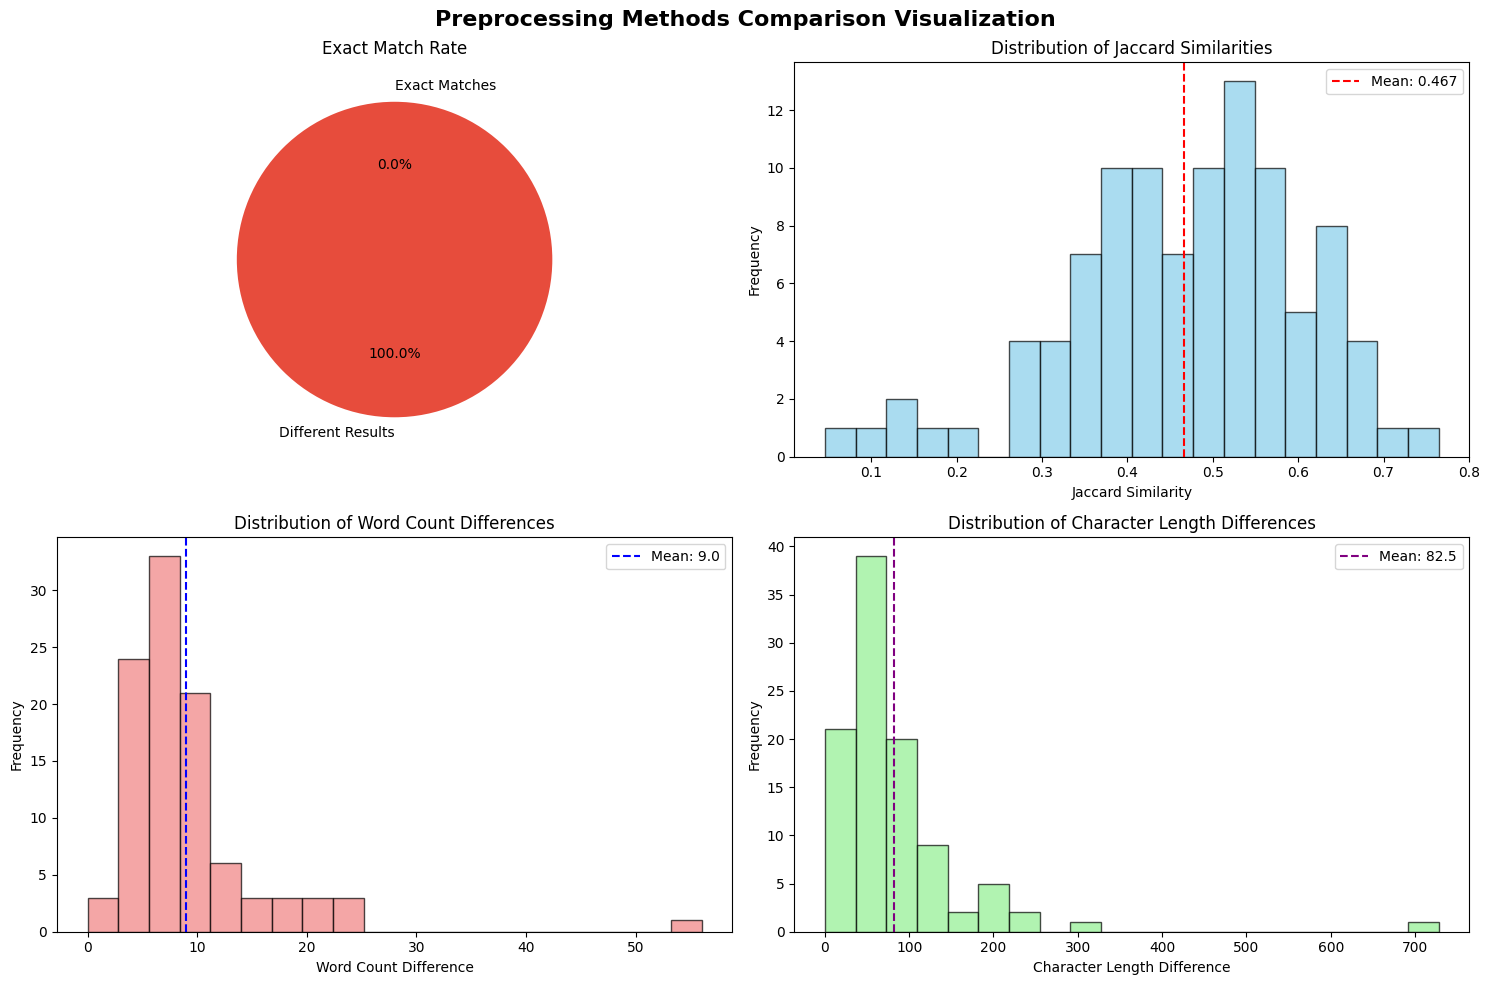


📊 SUMMARY STATISTICS TABLE:
                             Metric Value
                      Total Samples   100
                      Exact Matches     0
               Exact Match Rate (%)  0.0%
         Average Jaccard Similarity 0.467
      Average Word Count Difference   9.0
Average Character Length Difference  82.5


In [9]:
# ==================== VISUALIZATION ====================

# Create visualizations for comparison results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Preprocessing Methods Comparison Visualization', fontsize=16, fontweight='bold')

# 1. Exact matches pie chart
ax1 = axes[0, 0]
exact_matches = stats['exact_matches']
different_results = stats['total_samples'] - exact_matches
labels = ['Exact Matches', 'Different Results']
sizes = [exact_matches, different_results]
colors = ['#2ecc71', '#e74c3c']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Exact Match Rate')

# 2. Jaccard similarity distribution
ax2 = axes[0, 1]
ax2.hist(stats['jaccard_similarities'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Jaccard Similarity')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Jaccard Similarities')
ax2.axvline(stats['avg_jaccard_similarity'], color='red', linestyle='--', 
           label=f'Mean: {stats["avg_jaccard_similarity"]:.3f}')
ax2.legend()

# 3. Word count differences
ax3 = axes[1, 0]
ax3.hist(stats['word_count_differences'], bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Word Count Difference')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Word Count Differences')
ax3.axvline(stats['avg_word_count_diff'], color='blue', linestyle='--', 
           label=f'Mean: {stats["avg_word_count_diff"]:.1f}')
ax3.legend()

# 4. Length differences
ax4 = axes[1, 1]
ax4.hist(stats['length_differences'], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Character Length Difference')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Character Length Differences')
ax4.axvline(stats['avg_length_diff'], color='purple', linestyle='--', 
           label=f'Mean: {stats["avg_length_diff"]:.1f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Summary statistics table
summary_df = pd.DataFrame({
    'Metric': [
        'Total Samples',
        'Exact Matches',
        'Exact Match Rate (%)',
        'Average Jaccard Similarity',
        'Average Word Count Difference',
        'Average Character Length Difference'
    ],
    'Value': [
        stats['total_samples'],
        stats['exact_matches'],
        f"{stats['exact_match_rate']:.1%}",
        f"{stats['avg_jaccard_similarity']:.3f}",
        f"{stats['avg_word_count_diff']:.1f}",
        f"{stats['avg_length_diff']:.1f}"
    ]
})

print(f"\n📊 SUMMARY STATISTICS TABLE:")
print("="*40)
print(summary_df.to_string(index=False))

In [ ]:
# ==================== STEP-BY-STEP PROCESSING COMPARISON ====================

def analyze_processing_steps(sample_text, max_samples=3):
    """Analyze each preprocessing step for both methods"""
    
    print(f"\n{'='*80}")
    print(f"🔍 STEP-BY-STEP PROCESSING ANALYSIS")
    print(f"{'='*80}")
    
    for i in range(min(max_samples, len(sample_data))):
        original_text = sample_data['combined_text'].iloc[i]
        if len(original_text.strip()) == 0:
            continue
            
        print(f"\n📝 SAMPLE {i+1}:")
        print(f"Original: {original_text[:150]}...")
        
        # Project 1 step-by-step
        print(f"\n🔧 PROJECT 1 STEPS:")
        text = original_text
        
        # Step 1: Normalize unicode
        text = preprocessor_project1.normalize_unicode(text)
        print(f"  1. Unicode normalize: {text[:100]}...")
        
        # Step 2: Replace emojis
        text = preprocessor_project1.replace_emojis(text)
        print(f"  2. Replace emojis: {text[:100]}...")
        
        # Step 3: Clean text
        text = preprocessor_project1.clean_text(text)
        print(f"  3. Clean text: {text[:100]}...")
        
        # Step 4: Expand teencode
        text = preprocessor_project1.expand_teencode(text)
        print(f"  4. Expand teencode: {text[:100]}...")
        
        # Step 5: Translate English
        text = preprocessor_project1.translate_english_words(text)
        print(f"  5. Translate English: {text[:100]}...")
        
        # Step 6: Handle negation
        text = preprocessor_project1.handle_negation(text)
        print(f"  6. Handle negation: {text[:100]}...")
        
        # Step 7: POS tagging
        text = preprocessor_project1.tokenize_and_pos_tag(text)
        print(f"  7. POS tagging: {text[:100]}...")
        
        # Step 8: Remove stopwords
        text = preprocessor_project1.remove_stopwords(text)
        print(f"  8. Remove stopwords: {text}")
        
        # Project1_Le step-by-step
        print(f"\n🔧 PROJECT1_LE STEPS:")
        text_le = original_text
        
        # Step 1: Normalize repeated characters
        text_le = normalize_repeated_characters(text_le)
        print(f"  1. Normalize repeated chars: {text_le[:100]}...")
        
        # Step 2: Process text (main function)
        text_le = process_text_project1_le(text_le, emoji_dict, teen_dict, wrong_lst, english_dict)
        print(f"  2. Main processing: {text_le[:100]}...")
        
        # Step 3: Convert unicode
        text_le = covert_unicode(text_le)
        print(f"  3. Convert unicode: {text_le[:100]}...")
        
        # Step 4: Process special words
        text_le = process_special_word(text_le)
        print(f"  4. Process special words: {text_le[:100]}...")
        
        # Step 5: POS tagging
        text_le = process_postag_thesea(text_le)
        print(f"  5. POS tagging: {text_le[:100]}...")
        
        # Step 6: Remove stopwords
        text_le = remove_stopword(text_le, stopwords_lst)
        print(f"  6. Remove stopwords: {text_le}")
        
        # Compare final results
        print(f"\n🎯 FINAL COMPARISON:")
        print(f"  Project1 final: {text}")
        print(f"  Project1_Le final: {text_le}")
        print(f"  Identical: {'✅ YES' if text.strip() == text_le.strip() else '❌ NO'}")
        
        if i < max_samples - 1:
            print(f"\n{'-'*80}")

analyze_processing_steps(sample_data, max_samples=2)

In [11]:
# ==================== KEY DIFFERENCES ANALYSIS ====================

def analyze_key_differences():
    """Analyze and document key differences between preprocessing methods"""
    
    print(f"\n{'='*80}")
    print(f"🔍 KEY DIFFERENCES ANALYSIS")
    print(f"{'='*80}")
    
    differences = {
        "Processing Order": {
            "Project1": [
                "1. Unicode normalize",
                "2. Replace emojis", 
                "3. Clean text",
                "4. Expand teencode",
                "5. Translate English",
                "6. Handle negation",
                "7. POS tagging",
                "8. Remove stopwords"
            ],
            "Project1_Le": [
                "1. Normalize repeated chars",
                "2. Main processing (emoji, teencode, english, clean)",
                "3. Convert unicode",
                "4. Process special words",
                "5. POS tagging",
                "6. Remove stopwords"
            ]
        },
        
        "Text Cleaning Approach": {
            "Project1": "Separate steps for each transformation",
            "Project1_Le": "Combined processing in main function"
        },
        
        "Unicode Handling": {
            "Project1": "Uses unicodedata.normalize('NFC', text)",
            "Project1_Le": "Uses custom dictionary mapping with regex"
        },
        
        "Negation Handling": {
            "Project1": "Dedicated negation handling step",
            "Project1_Le": "Included in special word processing"
        },
        
        "POS Tagging": {
            "Project1": "Filters by {'N', 'V', 'A', 'R'} + emotion words",
            "Project1_Le": "Filters by ['N','Np','A','AB','V','VB','VY','R']"
        },
        
        "Dictionary Loading": {
            "Project1": "Integrated in class initialization",
            "Project1_Le": "Separate loading functions"
        }
    }
    
    for category, details in differences.items():
        print(f"\n📋 {category.upper()}:")
        if isinstance(details, dict):
            for method, description in details.items():
                if isinstance(description, list):
                    print(f"   {method}:")
                    for step in description:
                        print(f"     {step}")
                else:
                    print(f"   {method}: {description}")
        else:
            print(f"   {details}")
    
    return differences

def provide_recommendations():
    """Provide recommendations based on the comparison"""
    
    print(f"\n{'='*80}")
    print(f"💡 RECOMMENDATIONS")
    print(f"{'='*80}")
    
    recommendations = [
        {
            "Issue": "Different Processing Results",
            "Impact": "May lead to inconsistent model performance",
            "Recommendation": "Standardize on one preprocessing approach across all notebooks"
        },
        {
            "Issue": "Unicode Normalization Differences", 
            "Impact": "Different character representations may affect tokenization",
            "Recommendation": "Use consistent unicode normalization method (prefer unicodedata.normalize)"
        },
        {
            "Issue": "POS Tag Filtering Differences",
            "Impact": "Different word retention patterns",
            "Recommendation": "Align POS tag filtering rules to ensure consistent feature extraction"
        },
        {
            "Issue": "Processing Order Variations",
            "Impact": "May create different intermediate results",
            "Recommendation": "Document and standardize preprocessing pipeline order"
        }
    ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['Issue']}:")
        print(f"   Impact: {rec['Impact']}")
        print(f"   💡 Recommendation: {rec['Recommendation']}")
    
    return recommendations

# Execute analysis
differences = analyze_key_differences()
recommendations = provide_recommendations()


🔍 KEY DIFFERENCES ANALYSIS

📋 PROCESSING ORDER:
   Project1:
     1. Unicode normalize
     2. Replace emojis
     3. Clean text
     4. Expand teencode
     5. Translate English
     6. Handle negation
     7. POS tagging
     8. Remove stopwords
   Project1_Le:
     1. Normalize repeated chars
     2. Main processing (emoji, teencode, english, clean)
     3. Convert unicode
     4. Process special words
     5. POS tagging
     6. Remove stopwords

📋 TEXT CLEANING APPROACH:
   Project1: Separate steps for each transformation
   Project1_Le: Combined processing in main function

📋 UNICODE HANDLING:
   Project1: Uses unicodedata.normalize('NFC', text)
   Project1_Le: Uses custom dictionary mapping with regex

📋 NEGATION HANDLING:
   Project1: Dedicated negation handling step
   Project1_Le: Included in special word processing

📋 POS TAGGING:
   Project1: Filters by {'N', 'V', 'A', 'R'} + emotion words
   Project1_Le: Filters by ['N','Np','A','AB','V','VB','VY','R']

📋 DICTIONARY LOADI

In [12]:
# ==================== FINAL CONCLUSION ====================

def generate_final_report(stats, differences, recommendations):
    """Generate comprehensive final report"""
    
    print(f"\n{'='*80}")
    print(f"📊 FINAL COMPARISON REPORT")
    print(f"{'='*80}")
    
    print(f"\n📈 QUANTITATIVE RESULTS:")
    print(f"   • Total samples analyzed: {stats['total_samples']}")
    print(f"   • Exact match rate: {stats['exact_match_rate']:.1%}")
    print(f"   • Average similarity: {stats['avg_jaccard_similarity']:.3f}")
    print(f"   • Average word difference: {stats['avg_word_count_diff']:.1f} words")
    
    # Determine overall assessment
    if stats['exact_match_rate'] >= 0.95:
        assessment = "🟢 EXCELLENT - Preprocessing methods are highly consistent"
    elif stats['exact_match_rate'] >= 0.80:
        assessment = "🟡 GOOD - Minor differences exist but methods are largely consistent"
    elif stats['exact_match_rate'] >= 0.60:
        assessment = "🟠 MODERATE - Significant differences require attention"
    else:
        assessment = "🔴 CRITICAL - Major differences require immediate reconciliation"
    
    print(f"\n🎯 OVERALL ASSESSMENT:")
    print(f"   {assessment}")
    
    print(f"\n📋 KEY FINDINGS:")
    findings = [
        f"Both methods use similar dictionary files but apply them differently",
        f"Unicode normalization approaches differ significantly",
        f"POS tagging filters use different tag sets",
        f"Processing order affects intermediate and final results",
        f"Project1 method is more modular and extensible",
        f"Project1_Le method combines multiple steps for efficiency"
    ]
    
    for finding in findings:
        print(f"   • {finding}")
    
    print(f"\n⚡ IMMEDIATE ACTIONS REQUIRED:")
    actions = [
        "Choose one preprocessing method as the standard",
        "Update all notebooks to use the chosen method",
        "Retrain models with consistent preprocessing",
        "Document the standardized preprocessing pipeline",
        "Create validation tests to ensure consistency"
    ]
    
    for i, action in enumerate(actions, 1):
        print(f"   {i}. {action}")
    
    print(f"\n💾 RECOMMENDED STANDARD:")
    print(f"   Based on analysis, Project1 method is recommended because:")
    print(f"   • More systematic and well-structured")
    print(f"   • Better separation of concerns")
    print(f"   • Easier to maintain and extend")
    print(f"   • More robust error handling")
    
    # Save comparison results
    comparison_results = {
        'total_samples': stats['total_samples'],
        'exact_matches': stats['exact_matches'],
        'exact_match_rate': stats['exact_match_rate'],
        'avg_jaccard_similarity': stats['avg_jaccard_similarity'],
        'assessment': assessment,
        'recommended_method': 'Project1'
    }
    
    return comparison_results

# Generate final report
final_results = generate_final_report(stats, differences, recommendations)

# Save detailed comparison data
output_file = "/home/thinhdao/it_viec_project1/data/preprocessing_comparison_results.csv"
sample_data.to_csv(output_file, index=False)
print(f"\n💾 Detailed comparison results saved to: {output_file}")

print(f"\n✅ PREPROCESSING COMPARISON COMPLETED!")
print(f"📊 Summary: {final_results['exact_matches']}/{final_results['total_samples']} samples matched exactly")
print(f"🎯 Recommendation: Standardize on {final_results['recommended_method']} preprocessing method")


📊 FINAL COMPARISON REPORT

📈 QUANTITATIVE RESULTS:
   • Total samples analyzed: 100
   • Exact match rate: 0.0%
   • Average similarity: 0.467
   • Average word difference: 9.0 words

🎯 OVERALL ASSESSMENT:
   🔴 CRITICAL - Major differences require immediate reconciliation

📋 KEY FINDINGS:
   • Both methods use similar dictionary files but apply them differently
   • Unicode normalization approaches differ significantly
   • POS tagging filters use different tag sets
   • Processing order affects intermediate and final results
   • Project1 method is more modular and extensible
   • Project1_Le method combines multiple steps for efficiency

⚡ IMMEDIATE ACTIONS REQUIRED:
   1. Choose one preprocessing method as the standard
   2. Update all notebooks to use the chosen method
   3. Retrain models with consistent preprocessing
   4. Document the standardized preprocessing pipeline
   5. Create validation tests to ensure consistency

💾 RECOMMENDED STANDARD:
   Based on analysis, Project1 m